# Проект: Токсичные комментарии 
**Dataset Description:**
    
    Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
    
**Данные:**

 * `toxic_comments.csv` - Датасет с размеченными данными.
 
**Описание полей данных:**

Telegramm:
 * `text` - текст комментария
 * `toxic` - целевой признак
 
**Цели:**
 
 * Разработка модели бинарной классификации комментариев на токсичные и не токсичные, с значением метрики F1 не менее 0.75.
 
**Структура проекта:**
 Здесь будет содерждание
 
**Предмет исследования:**

 Набор данных с разметкой о токсичности правок.

**Методы:** которые мы применим в данном исследовании включают в себя: 
* Загрузка и ознакомление с данными
* Machine learning
* Future exctraction
* NLP


**Используемые библитеки:** 
* Scikit-learn
* Numpy
* Pandas
* Nltk
* Seaborn
* Optuna

### Импорт библиотек

Импортируем необходимые библиотеки и объявим константы:

In [1]:
!pip install WordCloud
!pip install --upgrade WordCloud
!pip install --upgrade pillow
!pip install beautifulsoup4
!pip install contractions
!pip install catboost
!pip install optuna
!pip install textblob
!pip install unidecode
!pip install wordnet

import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import contractions
import numpy as np
import string
import re
import os
import wordnet

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

from bs4 import BeautifulSoup
from lightgbm import LGBMClassifier
from textblob import TextBlob
from unidecode import unidecode
from catboost import CatBoostClassifier
from joblib import Parallel, delayed
from wordcloud import WordCloud
from PIL import ImageFont, ImageDraw

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

RANDOM_SEED = 12345
STOP_WORDS = set(nltk_stopwords.words('english'))
N_SPLITS = 5
STUDY = False

     |████████████████████████████████| 460 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
     |████████████████████████████████| 103 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 289 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 390 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 636 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 1.3 MB/s eta 0:00:01
  Created wheel for wordnet: filename=wordnet-0.0.1b2-py3-none-any.whl size=10521 sha256=b56d427dfb07c3a4a1cfca012c9700bcd3f4b4e916027b5484a8be1ec2237580
  Stored in directory: /home/jovyan/.cache/pip/wheels/01/be/ef/2424637bbd3690b10b7fc1c16faa12fdd053ff6b1abb2c3c08
Successfully built wordnet


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Загрузка и ознакомление с данными

Загрузим наши данные в переменную `data`:

In [2]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')  

Взглянем на первые 5 строк:

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Загрузка проведена корректно.
Посмотрим на общую информацию:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Столбец `Unnamed: 0` - на первый взгляд не несет никакой информации, избавимся от него на этапе подготовки данных, пропущенных значений нет.

Столбец `text` - 159292 значения, пропущенных значений нет, тип `object`

Столбец `text` - 159292 значения, пропущенных значений нет, тип `int64`

### Подготовка

In [5]:
data.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in r...",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61....,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted no...,0
159291,159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. Wh...",0


Избавимся от столбца `Unnamed: 0` т.к. он не несет никакой информации:

In [6]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Проверим столбец `toxic` на неявные дубликаты:

In [7]:
data.toxic.unique()

array([0, 1])

 Неявных дубликатов не обнаружено.
 
 А теперь проверим столбец `text` на дубликаты:

In [8]:
data.text.duplicated().sum()

0

Дубликатов не обнаруженно.

На этапе подготовки в данном проекте мы:
* Избавились от столбца `Unnamed: 0` т.к. он не несет никакой информации. 
* Проверили данные на явные/неявные дубликаты

### EDA

Взглянем на распределение целевого признака:

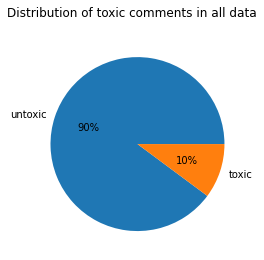

In [9]:
def rename_types_comments(data):
    type_comments  = list(data.unique())
    return list(map(lambda x: 'toxic' if x == 1 else 'untoxic', type_comments))

plt.pie(data.toxic.value_counts(), labels=rename_types_comments(data.toxic), autopct='%.0f%%')
plt.suptitle('Distribution of toxic comments in all data')
plt.show()

Только 10% комментариев размечены как токсичные. Взглянем на облака слов токсичных и не токсичных комментариев:

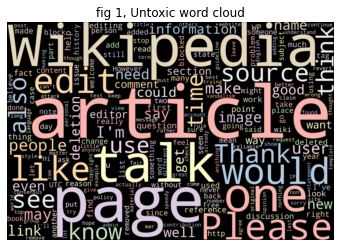

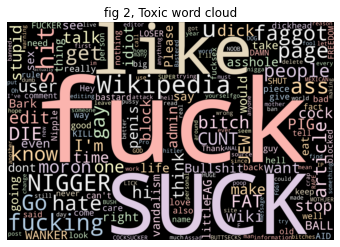

In [10]:
for toxic in list(data.toxic.unique()):
    text = data.loc[data.toxic==toxic, ['text']]

     # Извлечение текста
    text = " ".join(x for x in text.text)
    
     # Создание WordCloud
    word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color='black',
        colormap='Pastel1',
        collocations=False,
        stopwords=STOP_WORDS,
        ).generate(text)
    
     # Отрисовка
    plt.figure()
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    
    if toxic == 1:
        plt.title('fig 2, Toxic word cloud')
    else:
        plt.title('fig 1, Untoxic word cloud')
        
    plt.show()

Как мы можем заметить из облаков слов - такие слова как: 'Wikipedia', 'think', article' находятся в токсичных и не токсичных комментариях.

В общем плане картина выглядит адекватной, в токсичных комментариях - множество ругательств.

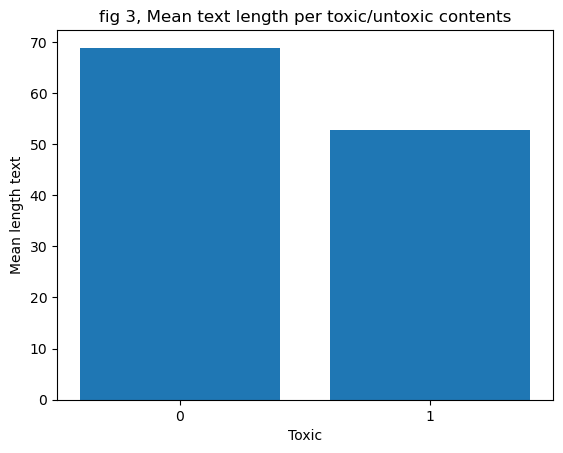

In [11]:
len_text = data.groupby(['toxic']).text.apply(lambda x: x.str.split().str.len().mean())

plt.bar(list(len_text.index), len_text)
plt.xticks(list(len_text.index))
plt.title('fig 3, Mean text length per toxic/untoxic contents')
plt.xlabel('Toxic')
plt.ylabel('Mean length text')
plt.show()

Как мы можем видеть на рисунке 3, средняя длинна токсичного комментария меньше не токсичного.

На этапе EDA мы установили:
* Только 10% процентов комментариев токсичны.
* Разметка данных на первый взгляд выглядит корректной.
* Некоторые слова содержаться в токсичных и не токсичных комментариях.
* Средняя длинна токсичных комментариев меньше чем не токсичных.

### Data preoprocessing

Для начала расширим ранее загруженный словарь стоп-слов, словами которые встречаются в обоих типах комментариях, либо не несут смысла:

In [12]:
STOP_WORDS.update(['wikipedia', 'think', 'article', 'dont', 'havent', 'wont', 'cannot', 'like', 'page', 'please', 'would', 'youre', 'people'])

В конвеере предобработки будем использовать лемматизацию при помощи WordNetLemmatizer(), для этого объявляем функцию lemmatize_text():

In [13]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    words = text.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    words = [w for w in words if len(w) > 2]
    return ' '.join(words)

Объявляем универсальный класс TextPreoprocessingSteps который содержит в себе распростарненые методы предобработки текстовых данных, в том числе и вызов функции лемматизации текста объявленную выше:

In [15]:
class TextPreoprocessingSteps:
    def __init__(self, X):
        self.X = X
        self.remove_punctuations = string.punctuation.replace('.','')
        
    def to_lower(self):
        self.X = self.X.apply(lambda x: x.lower())
        return self
    
    
    def remove_html_tags(self):
        def process_html(x):
            if isinstance(x, str) and "<" in x and ">" in x:
                return BeautifulSoup(x, "html.parser").get_text()
            return x
    
        self.X = self.X.apply(process_html)
        return self
    
    def replace_diacritics(self):
        self.X = self.X.apply(lambda x: unidecode(x, errors="preserve"))
        return self
    
    def expand_contractions(self):
        self.X = self.X.apply(lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]))
        return self
    
    def remove_numbers(self):
        self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
        return self
    
    def remove_punctuations_except_periods(self):
        self.X = self.X.apply(lambda x: re.sub('[%s]' % re.escape(self.remove_punctuations), '' , x))
        return self
    
    def remove_all_punctuations(self):
        self.X = self.X.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
        return self

    def replace_dots_with_spaces(self):
        self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
        return self
    
    def remove_double_spaces(self):
        self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
        return self
    
    def fix_typos(self):
        self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
        return self
    
    def remove_stopwords(self):
        self.X = self.X.apply(lambda x: " ".join([ word for word in x.split() if word not in STOP_WORDS]) )
        return self
    
    def lemmatize(self):
        
        self.X = self.X.apply(lambda x: lemmatize_text(x))
        return self
    
    def get_processed_text(self):
        return self.X

Объявляем класс TextPreoprocessor который является настраиваемым преобразователем текста:

In [16]:
class TextPreoprocessor(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self
    
    def transform(self, X):
        txt_preproc = TextPreoprocessingSteps(X.copy())
        processed_text = \
        txt_preproc \
            .to_lower()\
            .remove_all_punctuations()\
            .replace_diacritics()\
            .remove_html_tags()\
            .remove_numbers()\
            .remove_double_spaces()\
            .lemmatize()\
            .remove_stopwords()\
            .get_processed_text()
        
        return processed_text        

Обявляем пайплайн для предобработки текстовых данных и перевода в разряженные матрицы:

In [17]:
pure_transformation_pipeline = Pipeline(steps=[
           ('text_preproc', TextPreoprocessor()),
            ('tfidf', TfidfVectorizer())])

Разделим данные на тренировочную и тестовую выборки в отношении 90:10:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['toxic'], test_size=.10, random_state=123)

In [19]:
%time

X_train = pure_transformation_pipeline.fit_transform(X_train)
X_test = pure_transformation_pipeline.transform(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


Взглянем на распределение целевого признака в тренировочной и тестовой выборках:

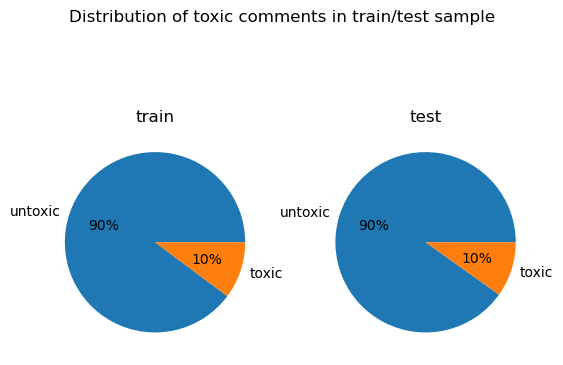

In [20]:
fig, axs = plt.subplots(nrows=1 , ncols=2)

fig.suptitle('Distribution of toxic comments in train/test sample')

axs[0].pie(y_train.value_counts(), labels=rename_types_comments(y_train), autopct='%.0f%%')
axs[0].set_title('train')

axs[1].pie(y_test.value_counts(), labels=rename_types_comments(y_test), autopct='%.0f%%')
axs[1].set_title('test')

plt.show()

Распределение токое же как и в общих данных.

На этапе `Data preoprocessing` произвели:
* Расширение словаря стоп-слов.
* Создание пайплайна для предобработки данных.
* Разделение данных на тренировочную и тестовую выборки.
* Контроль распределения целевого признака.

### Model searching

В качестве целевой метрики используем f-score.

На этапе поиска лучшей модели, мы будем сравнивать модели 'LogisticRegression', 'LGBMClassifier'. 

Подбор гиперпараметров будем осуществлять при помощи библиотеки Optuna. 

Обучение моделей будем производить с применением стратифицированной кросс-валидации на тренировочной части выборки с применением предобработки текстовых данных пайплайном и распараллеливанием. 

По целевой метрике выберем наилучщую модель а также для оценки адекватности предсказаний сравним тестируемые модели с 'DummyClassifier'.

Объявим разделитель, список моделей и список результатов:

In [21]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_SEED, shuffle=True)

train_scores = []
models_list = ['LogisticRegression', 'LGBMClassifier', 'DummyClassifier']

def train_and_evaluate_fold(train_index, test_index, model):
    
    X_train_fold, y_train_fold = X_train[train_index], y_train.iloc[train_index]
    X_test_fold, y_test_fold = X_train[test_index], y_train.iloc[test_index]

    #X_train_fold = pure_transformation_pipeline.fit_transform(X_train_fold)
    #X_test_fold = pure_transformation_pipeline.transform(X_test_fold)

    model.fit(X_train_fold, y_train_fold)
    prediction = model.predict(X_test_fold)

    fold_metric = f1_score(y_test_fold, prediction)
    
    return fold_metric

Обучение модели LogisticRegression():

In [22]:
def objective(trial):
    
    global best_metric_lr
    print("=" * 12 + f"START" + 12 * "=")
    
    best_metric_lr = 0
    metric = []
    
    if STUDY:
        params = {
            'C': trial.suggest_float('C', 0.01, 10.0),
            'solver': trial.suggest_categorical('solver', ['liblinear']),
            'max_iter': trial.suggest_int('max_iter', 600, 600)
        }
    else:
        params = {'C': 9.12953727023913, 
                  'solver': 'liblinear', 
                  'max_iter': 800}
    
    model = LogisticRegression(**params, random_state=RANDOM_SEED)
    
    cv_metrics = Parallel(n_jobs=-1, prefer="threads")(delayed(train_and_evaluate_fold)(train_index, test_index, model) for _, (train_index, test_index) in enumerate(skf.split(X_train, y_train)))
    cv_metrics = np.mean(cv_metrics)
    
    print(f'CV metrics consist {cv_metrics}') 
    print("=" * 12 + f"STOP" + 12 * "=")
    
    if cv_metrics > best_metric_lr:
        best_metric_lr = cv_metrics
    return cv_metrics

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1, show_progress_bar=True)

train_scores.append(best_metric_lr)

[I 2023-06-04 02:14:48,679] A new study created in memory with name: no-name-2942459c-1eea-4e48-9580-8e6b5e91252d
  0%|          | 0/1 [00:00<?, ?it/s]

============START============


Best trial: 0. Best value: 0.790241: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

CV metrics consist 0.7902414299864795
============STOP============
[I 2023-06-04 02:14:49,824] Trial 0 finished with value: 0.7902414299864795 and parameters: {}. Best is trial 0 with value: 0.7902414299864795.


Обучение модели LGBMClassifier():

In [23]:
def objective(trial):
    
    global best_metric_LGBM
    print("=" * 12 + f"START" + 12 * "=")
    best_metric_LGBM = 0
    metric = []
    
    if STUDY:
        params = {'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 10.0),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
            'max_bin': trial.suggest_int('max_bin', 200, 500),
            'random_state': RANDOM_SEED}
    else:
        params = {'learning_rate': 0.07208490505758047, 
                  'num_leaves': 806, 
                  'max_depth': 10, 
                  'min_child_samples': 31, 
                  'subsample': 0.8152522810758143, 
                  'colsample_bytree': 0.8493865098159314, 
                  'reg_alpha': 7.982054908344558, 
                  'reg_lambda': 2.8587184913405137, 
                  'min_split_gain': 2.986611375024477, 
                  'min_child_weight': 5.664961228783351, 
                  'n_estimators': 795, 
                  'scale_pos_weight': 2.4805559561530126, 
                  'subsample_freq': 5, 
                  'max_bin': 406
                 }
    
    model = LGBMClassifier(**params)
            
    cv_metrics = Parallel(n_jobs=-1, prefer="threads")(delayed(train_and_evaluate_fold)(train_index, test_index, model) for _, (train_index, test_index) in enumerate(skf.split(X_train, y_train)))
    cv_metrics = np.mean(cv_metrics)
    
    print(f'CV metrics consist {cv_metrics}') 
    print("=" * 12 + f"STOP" + 12 * "=")
    
    if cv_metrics > best_metric_LGBM:
        best_metric_LGBM = cv_metrics
    return cv_metrics

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1, show_progress_bar=True)

train_scores.append(best_metric_LGBM)

[I 2023-06-04 02:14:49,844] A new study created in memory with name: no-name-48555437-4e21-4545-9728-6354f5820a5a
  0%|          | 0/1 [00:00<?, ?it/s]

============START============


Best trial: 0. Best value: 0.652322: 100%|██████████| 1/1 [01:47<00:00, 107.80s/it]

CV metrics consist 0.652321872871682
============STOP============
[I 2023-06-04 02:16:37,639] Trial 0 finished with value: 0.652321872871682 and parameters: {}. Best is trial 0 with value: 0.652321872871682.


Обучение модели DummyClassifier():

In [24]:
metric = []
model = DummyClassifier(strategy='stratified')

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        
            X_train_fold, y_train_fold = X_train[train_index], y_train.iloc[train_index]
            X_test_fold, y_test_fold = X_train[test_index], y_train.iloc[test_index]
            
            #X_train_fold = pure_transformation_pipeline.fit_transform(X_train_fold)
            #X_test_fold = pure_transformation_pipeline.transform(X_test_fold)
            
           
            model.fit(X_train_fold, y_train_fold)
            prediction = model.predict(X_test_fold)
            
            fold_metric = f1_score(y_test_fold, prediction)
            metric.append(fold_metric)
            
cv_metrics = np.mean(np.array(metric))
train_scores.append(cv_metrics)

In [25]:
model_score_dict = {'model_name': models_list,
                    'f1_metrics': train_scores}

stat_table = pd.DataFrame(model_score_dict)
stat_table.sort_values('f1_metrics', ascending=False)

,model_name,f1_metrics
0,LogisticRegression,0.790241
1,LGBMClassifier,0.652322
2,DummyClassifier,0.099572


По результатам обучения и тестирования с кросс-валидаций, наилучший результат показала модель LogisticRegression с параметрами:

 * 'penalty': 'l1', 
 * 'C': 4.322938891093681, 
 * 'fit_intercept': True, 
 * 'solver': 'liblinear', 
 * 'max_iter': 305
 
 Модель показала метрику f1 0.768629, что сравнимо больше модели DummyClassifier и удовлетворяет условиям задачи: > 0.75.

На данном этапе мы обучили и сравнили несколько моделей машинного обучения, сравнили результаты и выбрали модель для финального тестирования.

### Final testing

Протестируем нашу модель на тестовой выборке данных:

In [26]:
params = {'C': 9.12953727023913, 
          'solver': 'liblinear', 
          'max_iter': 800
         }

model = LogisticRegression(**params)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

print(f'Финальная метрика f1 составила {f1_score(y_test, prediction)}')

Финальная метрика f1 составила 0.7768014059753954


Удалось получить метрику f1-score равную 0.77

Для оценки адекватности предсказаний модели, составим матрицу ошибок:

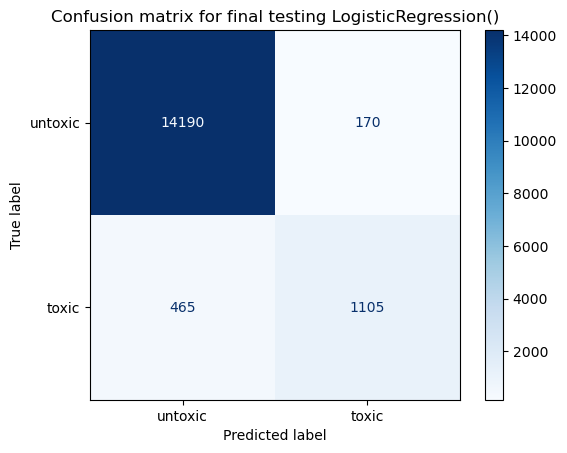

In [27]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rename_types_comments(y_train))
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrix for final testing LogisticRegression()')
plt.show()

Модель неплохо понимает данные. Взглянем на важность признаков для модели:

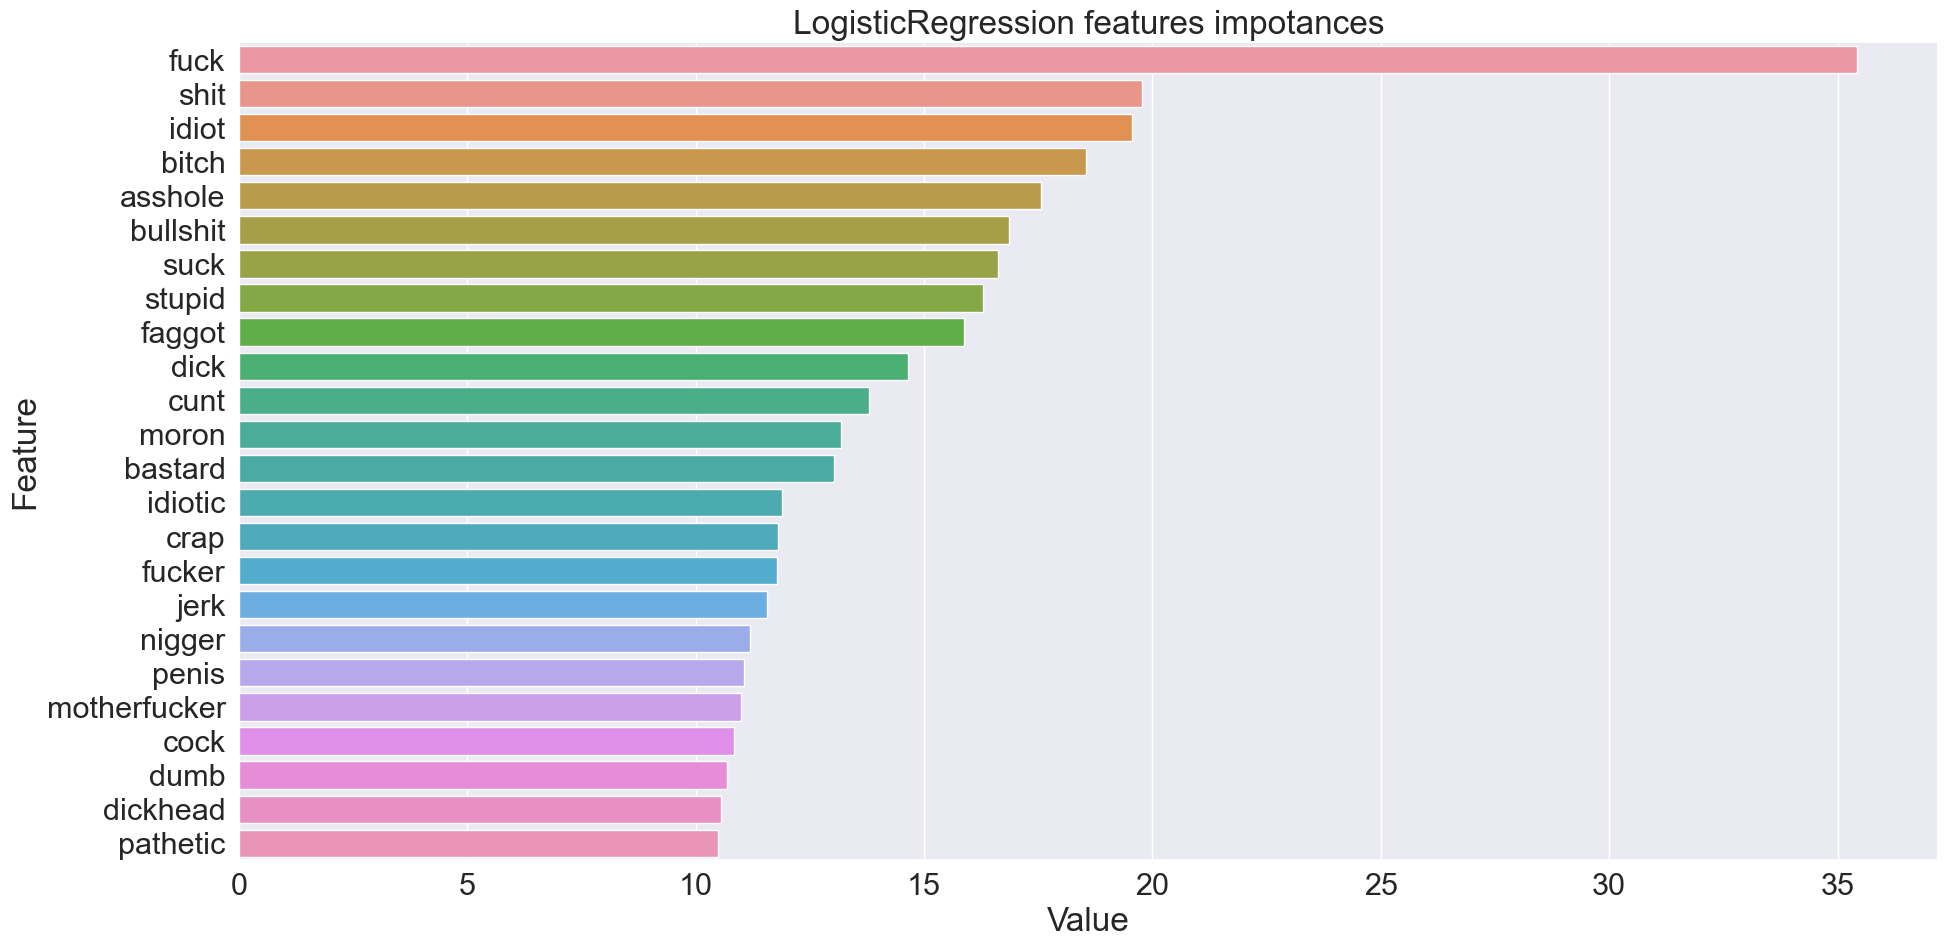

In [28]:
features_name = pure_transformation_pipeline[1].get_feature_names_out()

feature_imp = pd.DataFrame(sorted(
    zip(abs(model.coef_[0]), features_name)),
                           columns=['Value', 'Feature'])
plt.figure(figsize=(20, 10))
sns.set(font_scale=2)
sns.barplot(x='Value',
            y='Feature',
            data=feature_imp.sort_values(by='Value', ascending=False).head(24))
plt.title('LogisticRegression features impotances')
plt.tight_layout()
plt.show()

Модель определила что ругательства важны в классификации комментариев как токсичных.

### General conclusion

В данном проекте нашей основной задачей являлась разработка модели способной классифицировать комментарии на токсичные и не токсичные, а также не моловажное условие: метрика f1 разработанной модели должна быть более 0.75.

Для начала мы выполнили загрузку данных, ознакомились с общей информацией. Удалили не нужные столбцы из датасета.

Затем на этапе EDA мы выяснили что в токичных и не токсичных комментариях содержаться некоторые похожие слова, что длинна нетоксичных комментариев выше токсичных. Также мы проанализировали распределение токсичных комментариев в нашем датасете - оно составило 9 к 1 , т.е. на 9 не токсичных комментарие приходиться один токсичный.

На этапе предподготовки данных мы разработали пайплайн для предобработки текстовых данных и перешли к поиску модели. А еще мы разделили датасет на тренировочную и тестовую выборки в соотношении 90:10.

Для поиска наилучшей модели мы использовали стратифицированную кросс-валидацию с подбором гиперпараметров модели при помощи библиотеки Optuna.

По результатам обучения итестирования наилучшую метрику f1 показала модель LogisticRegression с результатом 0.768.

На тестовой выборке модели удалось увеличить метрику до 0.77, что удовлетворяет условиям проекта.

При анализе финальной модели мы составили матрицу ошибок по которой видно что модель понимает данные.

А также мы взглянули на признаки по которым модель определяет принадлежность комментария к токсичным, перед нами возник спллшной список ругательст, что говорит нам о выделении моделью этих слов - важной состовляющей токсичных комментариев.